In [30]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
# 가우스 함수
def gauss(x, mu, sigma):
    N, D = x.shape
    c1 = 1 / (2 * np.pi)**(D / 2)
    c2 = 1 / (np.linalg.det(sigma)**(1 / 2))
    inv_sigma = np.linalg.inv(sigma)
    c3 = x - mu
    c4 = np.dot(c3, inv_sigma)
    c5 = np.zeros(N)
    for d in range(D):
        c5 = c5 + c4[:, d] * c3[:, d]
    p = c1 * c2 * np.exp(-c5 / 2)
    return p

In [32]:
x = np.array([[1, 2], [2, 1], [3, 4]])
mu = np.array([1, 2])
sigma = np.array([[1, 0], [0, 1]])
print(gauss(x, mu, sigma))

[0.15915494 0.05854983 0.00291502]


In [33]:
# 혼합 가우시안 모델
def mixgauss(x, pi, mu, sigma):
    N, D = x.shape
    K = len(pi)
    p = np.zeros(N)
    for k in range(K):
        p = p + pi[k] * gauss(x, mu[k, :], sigma[k, :, :])
    return p

In [34]:
# test
x = np.array([[1, 2], [2, 2], [3, 4]])
pi = np.array([0.3, 0.7])
mu = np.array([[1, 1], [2, 2]])
sigma = np.array([[[1, 0], [0, 1]], [[2, 0], [0, 1]]])
print(mixgauss(x, pi, mu, sigma))

[0.09031182 0.09634263 0.00837489]


In [44]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline

# 혼합 가우스 등고선표시
def show_contour_mixgauss(pi, mu, sigma):
    xn = 40 # 등고선 표시 해상도
    x0 = np.linspace(X_range0[0], X_range0[1], xn)
    x1 = np.linspace(X_range1[0], X_range1[1], xn)
    xx0, xx1 = np.meshgrid(x0, x1)
    x = np.c_[np.reshape(xx0, xn * xn, 'F'), np.reshape(xx1, xn * xn, 'F')]
    f = mixgauss(x, pi, mu, sigma)
    f = f.reshape(xn, xn)
    f = f.T
    plt.contour(x0, x1, f, 10, colors='gray')
    
# 혼합 가우스 3D 표시
def show3d_mixgauss(ax, pi, mu, sigma):
    xn = 40 # 등고선 표시 해상도
    x0 = np.linspace(X_range0[0], X_range0[1], xn)
    x1 = np.linspace(X_range1[0], X_range1[1], xn)
    xx0, xx1 = np.meshgrid(x0, x1)
    x = np.c_[np.reshape(xx0, xn * xn, 'F'), np.reshape(xx1, xn * xn, 'F')]
    f = mixgauss(x, pi, mu, sigma)
    f = f.reshape(xn, xn)
    f = f.T
    ax.plot_surface(xx0, xx1, f, rstride=2, cstride=2, alpha=0.3,
                    color='blue', edgecolor='black')
    

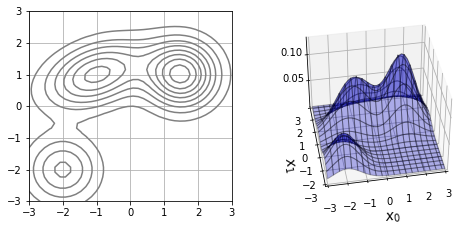

In [45]:
# test -----------------------------------
pi = np.array([0.2, 0.4, 0.4])
mu = np.array([[-2, -2], [-1, 1], [1.5, 1]])
sigma = np.array(
    [[[.5, 0], [0, .5]], [[1, 0.25], [0.25, .5]], [[.5, 0], [0, .5]]])


Fig = plt.figure(1, figsize=(8, 3.5))
Fig.add_subplot(1, 2, 1)
show_contour_mixgauss(pi, mu, sigma)
plt.grid(True)


Ax = Fig.add_subplot(1, 2, 2, projection='3d')
show3d_mixgauss(Ax, pi, mu, sigma)
Ax.set_zticks([0.05, 0.10])
Ax.set_xlabel('$x_0$', fontsize=14)
Ax.set_ylabel('$x_1$', fontsize=14)
Ax.view_init(40, -100)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.show()

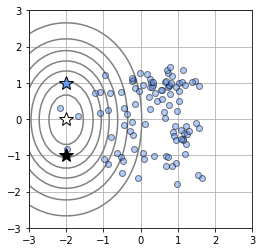

In [46]:
# 초기 설정
N = X.shape[0]
K = 3
Pi = np.array([0.33, 0.33, 0.34])
Mu = np.array([[-2, 1], [-2, 0], [-2, -1]])
Sigma = np.array([[[1, 0], [0, 1]], [[1, 0], [0, 1]], [[1, 0], [0, 1]]])
Gamma = np.c_[np.ones((N, 1)), np.zeros((N, 2))]

X_col = np.array([[0.4, 0.6, 0.95], [1, 1, 1], [0, 0, 0]])

# 데이터 그리기
def show_mixgauss_prm(x, gamma, pi, mu, sigma):
    N, D = x.shape
    show_contour_mixgauss(pi, mu, sigma)
    for n in range(N):
        col = gamma[n, 0]*X_col[0]+gamma[n, 1]*X_col[1]+gamma[n, 2]*X_col[2]
        plt.plot(x[n, 0], x[n, 1], 'o',
                color = tuple(col), markeredgecolor='black',
                markersize=6, alpha=0.5)
    
    for k in range(K):
        plt.plot(mu[k, 0], mu[k, 1], marker='*',
                markerfacecolor=tuple(X_col[k]), markersize=15,
                markeredgecolor='k', markeredgewidth=1)
        
    plt.grid(True)
    
plt.figure(1, figsize=(4, 4))
show_mixgauss_prm(X, Gamma, Pi, Mu, Sigma)
plt.show()
        

In [47]:
# gamma 갱신(E Step)
def e_step_mixgauss(x, pi, mu, sigma):
    N, D = x.shape
    K = len(pi)
    y = np.zeros((N, K))
    for k in range(K):
        y[:, k] = gauss(x, mu[k, :], sigma[k, :, :])  # K x N
    gamma = np.zeros((N, K))
    
    for n in range(N):
        wk = np.zeros(K)
        for k in range(K):
            wk[k] = pi[k] * y[n, k]
        gamma[n, :] = wk / np.sum(wk)
        
    return gamma

# 메인
Gamma = e_step_mixgauss(X, Pi, Mu, Sigma)

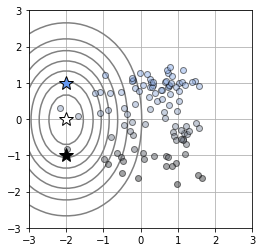

In [48]:
# 표시
plt.figure(1, figsize=(4, 4))
show_mixgauss_prm(X, Gamma, Pi, Mu, Sigma)
plt.show()

In [51]:
# Pi, Mu, Sigma 갱신(M Step)
def m_step_mixgauss(x, gamma):
    N, D = x.shape
    N, K = gamma.shape
    # pi를 계산
    pi = np.sum(gamma, axis=0) / N
    # mu를 계산
    mu = np.zeros((K, D))
    for k in range(K):
        for d in range(D):
            mu[k, d] = np.dot(gamma[:, k], x[:, d]) / np.sum(gamma[:, k])
        
    # sigma를 계산
    sigma = np.zeros((K, D, D))
    for k in range(K):
        for n in range(N):
            wk = x - mu[k, :]
            wk = wk[n, :, np.newaxis]
            sigma[k, :, :] = sigma[k, :, :] + gamma[n, k] * np.dot(wk, wk.T)
        sigma[k, :, :] = sigma[k, :, :] / np.sum(gamma[:, k])
    
    return pi, mu, sigma

# 메인
Pi, Mu, Sigma = m_step_mixgauss(X, Gamma)

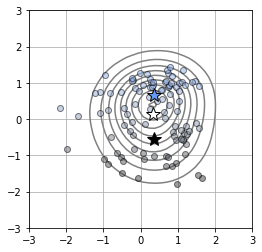

In [52]:
# 표시
plt.figure(1, figsize=(4, 4))
show_mixgauss_prm(X, Gamma, Pi, Mu, Sigma)
plt.show()

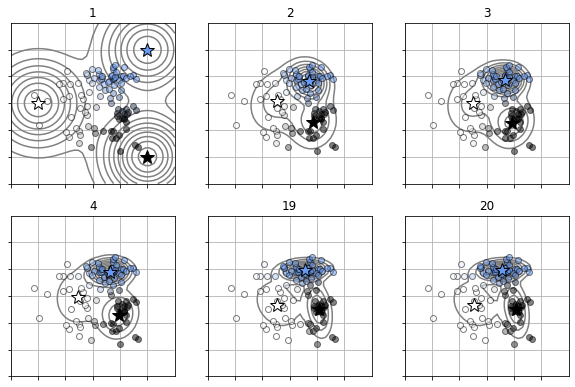

In [53]:
Pi = np.array([0.3, 0.3, 0.4])
Mu = np.array([[2, 2], [-2, 0], [2, -2]])
Sigma = np.array([[[1, 0], [0, 1]], [[1, 0], [0, 1]], [[1, 0], [0, 1]]])
Gamma = np.c_[np.ones((N, 1)), np.zeros((N, 2))]
plt.figure(1, figsize=(10, 6.5))
max_it = 20 # 반복횟수

i_subplot = 1;
for it in range(0, max_it):
    Gamma = e_step_mixgauss(X, Pi, Mu, Sigma)
    if it<4 or it> 17:
        plt.subplot(2, 3, i_subplot)
        show_mixgauss_prm(X, Gamma, Pi, Mu, Sigma)
        plt.title("{0:d}".format(it + 1))
        plt.xticks(range(X_range0[0], X_range0[1]), "")
        plt.yticks(range(X_range1[0], X_range1[1]), "")
        i_subplot = i_subplot + 1
        
    Pi, Mu, Sigma = m_step_mixgauss(X, Gamma)

plt.show()

In [54]:
# 혼합 가우스의 목적함수
def nlh_mixgauss(x, pi, mu, sigma):
    # x : N x D
    # pi : K x 1
    # mu : K x D
    # sigma : K x D x D
    # output lh : N x K
    N, D = x.shape
    K = len(pi)
    y = np.zeros((N, K))
    for k in range(K):
        y[:, k] = gauss(x, mu[k, :], sigma[k, :, :]) # K x N
    lh = 0
    
    for n in range(N):
        wk = 0
        for k in range(K):
            wk = wk + pi[k] * y[n, k]
        lh = lh + np.log(wk)
    
    return -lh

[426.22 229.86 224.32 220.8  218.63 216.93 215.93 215.51 215.33 215.24
 215.18 215.15 215.13 215.11 215.1  215.1  215.09 215.09 215.08 215.08]


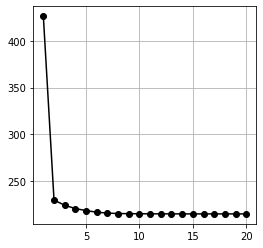

In [56]:
Pi = np.array([0.3, 0.3, 0.4])
Mu = np.array([[2, 2], [-2, 0], [2, -2]])
Sigma = np.array([[[1, 0], [0, 1]], [[1, 0], [0, 1]], [[1, 0], [0, 1]]])
Gamma = np.c_[np.ones((N, 1)), np.zeros((N, 2))]

max_it = 20
it = 0
Err = np.zeros(max_it)
for it in range(0, max_it):
    Gamma = e_step_mixgauss(X, Pi, Mu, Sigma)
    Err[it] = nlh_mixgauss(X, Pi, Mu, Sigma)
    Pi, Mu, Sigma = m_step_mixgauss(X, Gamma)
    
print(np.round(Err, 2))
plt.figure(2, figsize=(4, 4))
plt.plot(np.arange(max_it) + 1,
         Err, color='k', linestyle='-', marker='o')

plt.grid(True)
plt.show()